In [2]:
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from nltk.metrics.distance import jaccard_distance

### Part 1. Define function for querying datamuse.

In [3]:

def query_datamuse(word, n=100):
    query = "https://api.datamuse.com/words?ml={}&max={}".format(word, n)
    response = rq.get(query)
    results = []
    for obj in response.json(): 
        results.append(obj["word"])
    return results

In [4]:
#Load datasets 
mc = pd.read_csv("data/mc.csv", header=0, names=["word1", "word2", "score"], sep=";")
rg = pd.read_csv("data/rg.csv", header=0, names=["word1", "word2", "score"], sep=";")
wordsim = pd.read_csv("data/wordsim.csv", header=0, names=["word1", "word2", "score"], sep=";")

### Part 2. Define functions for calculating jaccard similarity from dataset.

In [5]:
def jaccard_similarity(set1, set2): 
    return 1 - jaccard_distance(set1, set2)

def datamuse_similarity(X, Y, n=100):
    words1 = query_datamuse(X, n=n)
    words2 = query_datamuse(Y, n=n)    
    return jaccard_similarity(set(words1), set(words2))

def calculate_similarities(df, n): 
    words1 = df["word1"].tolist()
    words2 = df["word2"].tolist()
    scores = df["score"].tolist()

    sim_values = []
    for w1, w2 in zip(words1, words2): 
        sim_values.append(datamuse_similarity(w1, w2, n=n))
        
    p = stats.pearsonr(sim_values, scores)
    return p



In [ ]:
calculate_similarities(mc, 100)

PearsonRResult(statistic=np.float64(0.6197982041050111), pvalue=np.float64(0.0003360473903788395))

### Find the N with highest Pearson correlation coefficient score.

In [7]:
def find_best_n(df): 
    d = {
        "n": [],
        "statistics": [],
        "pvalues": []
    }
    stats = []
    pvals = []
    for n in range(100, 1000, 100): 
        print("N: {}".format(n))
        p = calculate_similarities(mc, n)
        d["n"].append(n)
        d["statistics"].append(p.statistic)
        d["pvalues"].append(p.pvalue)
    
    return d

d = find_best_n(mc)
df = pd.DataFrame.from_dict(d)

N: 100
N: 200
N: 300
N: 400
N: 500
N: 600
N: 700
N: 800
N: 900


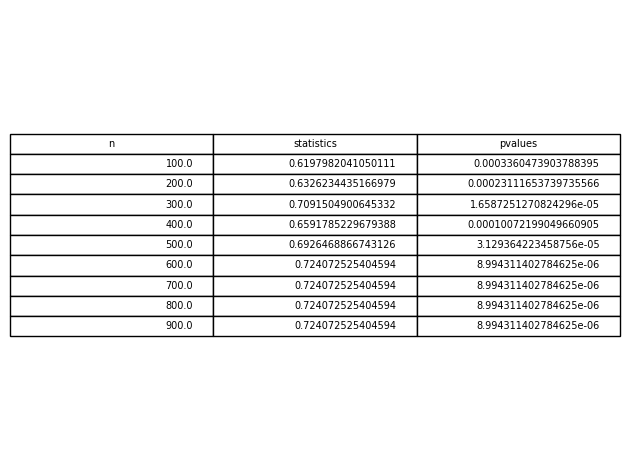

In [8]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()

In [9]:
# Get the N value with highest Pearson correlation coefficient score
max_id = df['statistics'].idxmax()
N = int(df.iloc[max_id]["n"])
print(N)

600


### Calculate correlation coefficients for all datasets.

In [10]:
p_mc = calculate_similarities(mc, N)
p_rg = calculate_similarities(rg, N)
p_wordsim = calculate_similarities(wordsim, N)
print(p_mc)
print(p_rg)
print(p_wordsim)

PearsonRResult(statistic=np.float64(0.724072525404594), pvalue=np.float64(8.994311402784625e-06))
PearsonRResult(statistic=np.float64(0.7850157130429563), pvalue=np.float64(1.6236618035026146e-14))
PearsonRResult(statistic=np.float64(0.49022656405756004), pvalue=np.float64(1.1105676505687779e-22))


# Part 3 - Apply the method in part 2 on sentence level

In [11]:
# get sentence bag of similartities words

def get_bag_of_words(sentence): 
    words = sentence.split(" ")
    bag = set(words)
    for word in words: 
        bag = bag.union(set(query_datamuse(word, n=N)))
    return bag

def get_sentence_similarity(sentence1, sentence2):
    bag1 = get_bag_of_words(sentence1)
    bag2 = get_bag_of_words(sentence2)
    return jaccard_similarity(bag1, bag2)

# Part 4

In [12]:
sentence_pairs_list = [
    ["Today is quite hot for a winter.", "Never is warm in winter."],
    ["The car is running fast but has some troubles recently.", "Toyota cars are recalled for a fault."],
    ["The teacher cannot do it again and never again.", "Teacher has been prohibited from this task."]
]

In [13]:
results = []
for pair in sentence_pairs_list: 
    results.append(get_sentence_similarity(pair[0], pair[1]))

# create a table
d = {
    "sentence1": [x[0] for x in sentence_pairs_list],
    "sentence2": [x[1] for x in sentence_pairs_list],
    "similarity": results
}

df = pd.DataFrame.from_dict(d)
df

,sentence1,sentence2,similarity
0,Today is quite hot for a winter.,Never is warm in winter.,0.141104
1,The car is running fast but has some troubles ...,Toyota cars are recalled for a fault.,0.078636
2,The teacher cannot do it again and never again.,Teacher has been prohibited from this task.,0.175842


# Part 5

In [26]:
import time

# Load the STSS-131 dataset
stss = pd.read_csv("data/STSS-131.tsv", header=0, names=["sent1", "sent2", "score", "score2"], sep="\t")
stss["datamuse_similarity"] = np.nan

# Load half-completed data
from pathlib import Path
if (Path("data")  / "STSS-131-datamuse.tsv").is_file():
    stss = pd.read_csv("data/STSS-131-datamuse.tsv", sep="\t")

# Use this due to performance issues
N = 200

try:
    for i, row in stss.iterrows(): 
        print("Processing row {}".format(i))
        
        # skip if already calculated
        if not np.isnan(stss.at[i, "datamuse_similarity"]):
            print("Skipping row {}".format(i))
            continue

        stss.at[i, "datamuse_similarity"] = get_sentence_similarity(row["sent1"], row["sent2"])
        time.sleep(1)
except Exception as e:
    print(e)
finally:
    # Because of timeouts, save the results to a file
    stss.to_csv("data/STSS-131-datamuse.tsv", sep="\t", index=False)

stss.head()

stss_p = stats.pearsonr(stss["datamuse_similarity"], stss["score"])
print("Pearson correlation coefficient: {} p-value: {}".format(stss_p[0], stss_p[1]))

Processing row 0
Skipping row 0
Processing row 1
Skipping row 1
Processing row 2
Skipping row 2
Processing row 3
Skipping row 3
Processing row 4
Skipping row 4
Processing row 5
Skipping row 5
Processing row 6
Skipping row 6
Processing row 7
Skipping row 7
Processing row 8
Skipping row 8
Processing row 9
Skipping row 9
Processing row 10
Skipping row 10
Processing row 11
Skipping row 11
Processing row 12
Skipping row 12
Processing row 13
Skipping row 13
Processing row 14
Skipping row 14
Processing row 15
Skipping row 15
Processing row 16
Skipping row 16
Processing row 17
Skipping row 17
Processing row 18
Skipping row 18
Processing row 19
Skipping row 19
Processing row 20
Skipping row 20
Processing row 21
Skipping row 21
Processing row 22
Skipping row 22
Processing row 23
Skipping row 23
Processing row 24
Skipping row 24
Processing row 25
Skipping row 25
Processing row 26
Skipping row 26
Processing row 27
Skipping row 27
Processing row 28
Skipping row 28
Processing row 29
Skipping row 29


# Part 6

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
tf_idf_matrix = vectorizer.fit_transform(stss["sent1"], stss["sent2"])

cosine_similarities = []
for i in range(len(stss)):
    sent1_vector = vectorizer.transform([stss["sent1"][i]])
    sent2_vector = vectorizer.transform([stss["sent2"][i]])
    cosine_similarities.append(cosine_similarity(sent1_vector, sent2_vector)[0][0])

tfidf_p = stats.pearsonr(cosine_similarities, stss["score"])
print("Pearson correlation coefficient: {} p-value: {}".format(tfidf_p[0], tfidf_p[1]))

Pearson correlation coefficient: 0.776216151106484 p-value: 2.0516274140670272e-27
